In [1]:
from binance.spot import Spot 
from sys import stderr
import sys, os,datetime,requests,json,pandas as pd,numpy as np
import time,math, gc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn.model_selection import train_test_split
min_max_scaler = sklearn.preprocessing.MinMaxScaler()



import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def import_api(time_last,symbol="BTCUSDT",limit=12*60):
    params={"symbol":symbol,"limit":limit,"interval":"1m","endTime":time_last,"startTime":(time_last-12*3600*1000)}
    r=requests.get(url="https://api.binance.com/api/v3/klines", params=params)
    df=pd.DataFrame(r.json())
    return df

def transform_df (df):
    column_names=['Open_time','Open','High','Low','Close','Volume','Close_time','Quote_asset_volume',
               'Number_of_trades','Taker_buy_base_asset_volume','Taker_buy_quote_asset_volume','Ignore']
    df=df.reset_index(drop=True)
    df.set_axis(column_names,axis=1,inplace=True)
    for col in df.columns:
        df[col] = df[col].astype(float)
    weekday=[]
    month=[]
    for i in range(df['Open'].size):
        dt_open=datetime.datetime.fromtimestamp(df['Open_time'][i]//1000)
        dt_close=datetime.datetime.fromtimestamp(df['Close_time'][i]//1000)
        df['Open_time'][i]=dt_open.hour*3600+dt_open.minute*60+dt_open.second
        df['Close_time'][i]=dt_close.hour*3600+dt_close.minute*60+dt_close.second
        weekday.append(dt_open.weekday())
        month.append(dt_open.month)
        #df['Open_time'][i]=dt_open.strftime("%I:%M:%S")
        #df['Close_time'][i]=dt_close.strftime("%I:%M:%S")
    df['weekday']=weekday
    df['month']=month
    df=df.drop(df.columns[[7,10,11,13]],axis=1)
    del(month)
    del(weekday)
    return df


def moving_average(data,range_,concat=60):
    leftover=len(data)%concat
    data=data[::concat].reset_index(drop=True)
    mean=[]
    arr=[]
    for i in range(range_):
        this_mean=0
        for j in range(i+1):
            this_mean+=data[j]
        mean.append(this_mean/(j+1))
    if leftover:
        data_size=len(data)-1
    else:
        data_size=len(data)
    for i in range(range_,data_size):
        this_mean=data[i]
        for j in range(1,range_):
            this_mean+=data[i-j]
        mean.append(this_mean/(range_))
    arr=leftover*[mean[0]]
    for i in range(len(mean)):
        arr+=concat*[mean[i]]
    
    
    return arr

def generate_previous(df,count,col_name):
    #idxes=
    df=df.reset_index(drop=True)
    values=list(df[col_name][0:count])
    columns={}
    for i in range(count):
        this_name="prev_"+col_name+"_"+str(i+1)
        columns[this_name]=[]
    for i in range(count,df[col_name].size):
        for j in range(count):
            this_name="prev_"+col_name+"_"+str(j+1)
            columns[this_name].append(values[-(j+1)])
        values.pop(0)
        values.append(df[col_name][i])
    size=df[col_name].size
    df=df[count:size]
    for i in range(count):
        this_name="prev_"+col_name+"_"+str(i+1)
        df[this_name]=columns[this_name]
    
    return df.reset_index(drop=True)

def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [a for a in (df.iloc[i:i+window_size].drop("target",axis=1).values)]
        X.append(row)
        label = df["target"][i+window_size-1]
        y.append(label)
    return np.array(X), np.array(y)

def tensor_to_X_y(data, window_size=5):
    X = []
    y = []
    data=pd.DataFrame(data.tolist())
    columns=data.columns
    for i in range(len(data)-window_size):
        row = [a for a in (data.iloc[i:i+window_size].drop(data.columns[-1],axis=1).values)]
        X.append(row)
        label = data[data.columns[-1]][i+window_size-1]
        y.append(label)
    return np.array(X), np.array(y)
def preprocess_df(df,target_range,hours,hours_interval,days,days_interval,scaling_range=0.2):
    target=[]
    concat_hours=3
    concat_days=8
    window=target_range
    for i in range(df["Open"].size-window):
        target.append(df["Open"][i+window])
    df=df[0:df["Open"].size-window]
    df["target"]=target
    df=df.drop(["Close_time","Taker_buy_base_asset_volume","Volume","Close","Low","High","Number_of_trades"],axis=1)
    for i in range(1,hours//hours_interval+1):
        df["mean_"+str(i*hours_interval)+"_hours"]=moving_average(df["Open"],i*(12//concat_hours)*hours_interval,concat_hours)
    for i in range(1,days//days_interval+1):
        df["mean_"+str(i*days_interval)+"_days"]=moving_average(df["Open"],i*12*(24//concat_days)*days_interval,concat_days)
    drop_col=["Open",'Open_time','weekday']
    open_delta=[]
    df["weekday"]=df["weekday"].astype(float)
    for col in df.drop(drop_col,axis=1).columns:
        for i in range(df["Open"].size):
            df[col][i]=df[col][i]/df["Open"][i]
    for i in range(1,df["Open"].size):
        df["Open_time"][i]/=86400
        df["weekday"][i]/=6.0
        delta=df["Open"][i]-df["Open"][i-1]
        open_delta.append(delta/df["Open"][i])
    df=df.drop(0,axis=0)
    cols=df.columns[3:]
    for i in cols:
        for j in range(1,df["Open"].size):
            df[i][j]=(df[i][j]-(1-scaling_range))/(scaling_range*2)
    return df

def upscale(input_data,scaling_range):
    return input_data*2*scaling_range-scaling_range+1

In [ ]:
directory="G:\Учеба\биржа"

In [5]:
df=pd.read_csv(directory+'\\eth_usdt_5min.csv')[20000:220000].reset_index(drop=True)
df=preprocess_df(df,4,24,1,15,1)

C:\Users\DANIEL~1\AppData\Local\Temp/ipykernel_6484/710069263.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"]=target


In [6]:
df

,Open_time,Open,weekday,target,mean_1_hours,mean_2_hours,mean_3_hours,mean_4_hours,mean_5_hours,mean_6_hours,...,mean_6_days,mean_7_days,mean_8_days,mean_9_days,mean_10_days,mean_11_days,mean_12_days,mean_13_days,mean_14_days,mean_15_days
1,0.927083,1948.28,0.333333,0.500026,0.517207,0.517207,0.517207,0.517207,0.517207,0.517207,...,0.517207,0.517207,0.517207,0.517207,0.517207,0.517207,0.517207,0.517207,0.517207,0.517207
2,0.930556,1966.87,0.333333,0.480044,0.493416,0.493416,0.493416,0.493416,0.493416,0.493416,...,0.493416,0.493416,0.493416,0.493416,0.493416,0.493416,0.493416,0.493416,0.493416,0.493416
3,0.934028,1958.46,0.333333,0.492737,0.502062,0.502062,0.502062,0.502062,0.502062,0.502062,...,0.504123,0.504123,0.504123,0.504123,0.504123,0.504123,0.504123,0.504123,0.504123,0.504123
4,0.937500,1946.10,0.333333,0.487642,0.517953,0.517953,0.517953,0.517953,0.517953,0.517953,...,0.520027,0.520027,0.520027,0.520027,0.520027,0.520027,0.520027,0.520027,0.520027,0.520027
5,0.940972,1948.30,0.333333,0.494688,0.515109,0.515109,0.515109,0.515109,0.515109,0.515109,...,0.517182,0.517182,0.517182,0.517182,0.517182,0.517182,0.517182,0.517182,0.517182,0.517182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85033,0.447917,2070.55,0.666667,0.489097,0.520547,0.533919,0.538233,0.533444,0.530005,0.517737,...,0.824131,0.884462,0.946661,1.007834,1.046077,1.080020,1.105423,1.125922,1.147639,1.173237
85034,0.451389,2059.36,0.666667,0.499490,0.534243,0.547688,0.552025,0.547211,0.543752,0.531418,...,0.839477,0.900135,0.962672,1.024177,1.062629,1.096756,1.122297,1.142908,1.164742,1.190479
85035,0.454861,2057.97,0.666667,0.506851,0.525219,0.541222,0.551567,0.545448,0.545482,0.535363,...,0.841395,0.902094,0.964673,1.026220,1.064697,1.098848,1.124405,1.145030,1.166880,1.192634
85036,0.458333,2048.17,0.666667,0.520433,0.537302,0.553381,0.563775,0.557627,0.557661,0.547494,...,0.854990,0.915980,0.978858,1.040700,1.079361,1.113675,1.139355,1.160079,1.182032,1.207910


In [7]:
class autoencoder(nn.Module):
    def __init__(self,drop,hidden_size,test_size):
        super(autoencoder, self).__init__()
        self.norm=nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(41,hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc3 = nn.Linear(hidden_size, test_size,bias=True)
        self.fc4 = nn.Linear(test_size, hidden_size,bias=True)
        self.fc5 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc6 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc7 = nn.Linear(hidden_size, 41,bias=True)
        self.dropout = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.dropout(F.relu(x))
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = self.dropout(F.relu(x))
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)
        return x
    def encode (self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return x

In [8]:
encoder=autoencoder(0,64,10).cuda().double()
encoder.load_state_dict(torch.load(directory+'\\encoder_05-07-2022_22-03-48_64_10.pth'))
encoder.eval()

autoencoder(
  (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=41, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=41, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

In [9]:
encoded=encoder.encode(torch.tensor(df.drop(["Open","target"],axis=1).to_numpy(),device="cuda"))

In [10]:
encoded[:,0]

tensor([1.4320, 1.4423, 1.4457,  ..., 3.8837, 3.8901, 2.2049], device='cuda:0',
       dtype=torch.float64, grad_fn=<SelectBackward0>)

In [11]:
encoded.shape

torch.Size([85037, 10])

In [12]:
arr=torch.tensor([0 for i in encoded[:,0]],device="cuda")
count=0
for i in range(encoded.shape[1]):
    if (set(encoded[:,i].tolist())!={0.0}):
        arr=torch.cat((arr,encoded[:,i]),0)
        count+=1
arr=torch.reshape(arr,[count+1,encoded.shape[0]])[1:]
arr=torch.reshape(arr,[encoded.shape[0],count])
arr.shape

torch.Size([85037, 3])

In [13]:
arr=torch.cat([arr,torch.tensor(df[["Open","target"]].to_numpy(),device="cuda")],1)

In [14]:
pd.DataFrame(arr.tolist()).columns[-1]

4

In [15]:
arr.shape

torch.Size([85037, 5])

In [16]:
window_size=30
#X,y=df_to_X_y(df,window_size)
X,y=tensor_to_X_y(arr,window_size)
#del(df)


In [17]:
X.shape

(85007, 30, 4)

In [18]:
y.shape

(85007,)

In [19]:
#X_train.shape

In [20]:
#LSTM##

class Net(nn.Module):
    def __init__(self,drop,hidden_size,input_size):
        super(Net, self).__init__()
        self.norm=nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.LSTM(num_layers=1,input_size=input_size, hidden_size=hidden_size,batch_first=True)
        self.fc2 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc3 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc4 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc5 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc6 = nn.Linear(hidden_size, 1,bias=True)
        self.dropout = nn.Dropout(drop)
    def forward(self, x):
        x,_ = self.fc1(x)
        x=x[:,-1,:]
        x=F.tanh(x)
        x = self.dropout(x)
        x = F.logsigmoid(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x
    def predict(self, x):
        x,_ = self.fc1(x)
        x=x[:,-1,:]
        #x=F.tanh(x)
        x = self.dropout(x)
        x = F.logsigmoid(self.fc5(x))
        #x = self.dropout(x)
        x = self.fc6(x)
        return x

In [21]:
#y_train

In [22]:
def mae_func(pred_data,real_data):
    mae=0
    for i in range(len(pred_data)):
        mae+=abs(pred_data[i]-real_data[i])
    mae/=len(pred_data)
    return mae

In [24]:
def train(learning_rate,batch_size,epochs,momentum,decay=0,min_error=0,direction_punish=0,direction_reward=0):
    scaling_range=0.2
    global net
    parting=X_train.shape[0]//500
    X_test_part=X_test[::parting]
    X_train_part=X_train[::parting*10]
    y_test_part=y_test[::parting]
    y_train_part=y_train[::parting*10]
    train_batches=math.ceil(len(X_train)/batch_size)-1
    #net = Net(drop,hidden_size,X_train.shape[-1]).to(device).double()
    #optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum,weight_decay=decay)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=decay)
    #criterion = nn.MSELoss()
    criterion = nn.L1Loss()
    train_loss=nn.L1Loss()
    loss_train=[]
    loss_test=[]
    y_test_part_scaled=torch.tensor(y_test_part,device="cuda")
    y_train_part_scaled=torch.tensor(y_train_part,device="cuda")
    X_train_part_opens=X_train_opens[::parting*10]
    X_test_part_opens=X_test_opens[::parting]
    y_test_part_scaled=upscale(y_test_part_scaled,scaling_range)*X_test_part_opens
    y_train_part_scaled=upscale(y_train_part_scaled,scaling_range)*X_train_part_opens
    for epoch in range(epochs):
        for batch in range(train_batches):
            X_train_batch=X_train[batch*batch_size:(batch_size*(batch+1))]
            X_opens_batch=X_train_opens[batch*batch_size:(batch_size*(batch+1))]
            y_train_batch=torch.tensor(y_train[batch*batch_size:(batch_size*(batch+1))],device="cuda")
            y_targets=upscale(y_train_batch,scaling_range)*X_opens_batch
            net_out=net(torch.tensor(X_train_batch,device="cuda") ).reshape(-1,1)#*X_opens_batch
            loss = criterion(net_out, torch.tensor(y_train_batch,device="cuda"))
            #loss = torch.sqrt(criterion(net_out, torch.tensor(y_train_batch,device="cuda")))
            #loss_train.append( loss)
            #loss_test.append(criterion (net(torch.tensor(X_test[::100],device="cuda")),torch.tensor(y_test[::100],device="cuda")))
            #print(net_out)
            for i in range(net_out.shape[0]):
                if((net_out[i]-0.5)*(y_train_batch[i]-0.5)<0):
                    loss*=(1+direction_punish)
                else:
                    loss*=(1-direction_reward)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            #net_out_test=net(torch.tensor(X_test_part,device="cuda"))
            net_out_test=upscale(net(torch.tensor(X_test_part,device="cuda")),scaling_range)*X_test_part_opens.reshape(-1,1)
            #print(net_out_test[:20])
            mae=mae_func(net_out_test,y_test_part_scaled)
            loss_test.append(mae[0].item())
            #net_out_train=net(torch.tensor(X_train_part,device="cuda"))
            net_out_train=upscale(net(torch.tensor(X_train_part,device="cuda")),scaling_range)*X_train_part_opens#.reshape(-1,1)
            loss_train.append(train_loss(net_out_train,y_train_part_scaled).item())
        gc.collect()
        if (loss_test[-1]<min_error):
            break
    return loss_train,loss_test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size = 0.10,
                                                        random_state =123,
                                                        shuffle=False)
#X_train_opens=torch.tensor(X_train[:,:,1][:,window_size-1],device="cuda") #for df_to_x_y
#X_test_opens=torch.tensor(X_test[:,:,1][:,window_size-1],device="cuda")
#X_train=np.concatenate([X_train[:,:,2:],X_train[:,:,[0]]],axis=2)
#X_test=np.concatenate([X_test[:,:,2:],X_test[:,:,[0]]],axis=2)

X_train_opens=torch.tensor(X_train[:,:,-1][:,window_size-1],device="cuda") #for tensor_to_x_y
X_test_opens=torch.tensor(X_test[:,:,-1][:,window_size-1],device="cuda")
X_train=X_train[:,:,:-1]
X_test=X_test[:,:,:-1]

<AxesSubplot:>

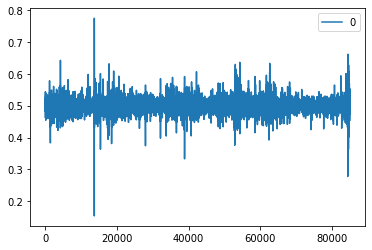

In [26]:
pd.DataFrame(y).plot()

In [50]:
#LOAD NET
#name="\\net_23-07-2022_16-40-32_3_96"
#path=directory+name
#net=Net(0.6,96,3).cuda().double()
#net.load_state_dict(torch.load(path+".pth"))
#net.eval()

In [27]:
hidden_size=96
drop=0.6
net = Net(drop,hidden_size,X_train.shape[-1]).to(device).double()


In [49]:
loss_train_single,loss_test_single=train(learning_rate=0.001, batch_size=25, epochs=50, momentum=0.9,decay=0.007,min_error=7.5,direction_punish=0.04,direction_reward=0.02)


G:\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\DANIEL~1\AppData\Local\Temp/ipykernel_6484/1113195600.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(net_out, torch.tensor(y_train_batch,device="cuda"))
G:\anaconda3\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
G:\anaconda3\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([51])) that is d

KeyboardInterrupt: 

In [48]:
#SAVE NET
time_now=datetime.datetime.now()
time_now=time_now.strftime("\\net_%d-%m-%Y_%H-%M-%S_")+str(X_test.shape[2])+"_"+str(hidden_size)
path=directory
end=".pth"
path=path+time_now+end
torch.save(net.state_dict(), path)

<AxesSubplot:>

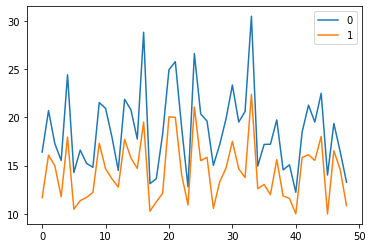

In [40]:
pd.DataFrame([loss_train_single[1:],loss_test_single[1:]]).T.plot()

In [41]:
loss_test_single[-1]

10.849590892956606

In [42]:
np.min(loss_test_single)

9.987332104548228

In [171]:
np.std(net(torch.tensor(X_test[:100],device="cuda") ).tolist())

G:\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0.005732831134146506

G:\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


<AxesSubplot:>

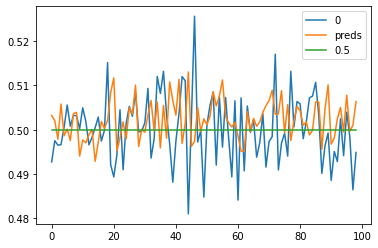

In [47]:
#pd.DataFrame([loss_train[-0:][33],loss_test[-0:][33]]).T.plot()
#preds=pd.DataFrame(net.predict(torch.tensor(X_test[::100][:-10],device="cuda") ).tolist())
#preds=pd.DataFrame(net(torch.tensor(X_test[::100][:-10],device="cuda") ).tolist())
array=[]
preds=[]
for i in range(1):
    array.append(net(torch.tensor(X_test[::75][:-15],device="cuda") ).tolist())
array=np.asarray(array)
for i in range(len(array[0])):
    preds.append(np.mean(array[:,i]))
preds=pd.DataFrame(preds)    

data=pd.DataFrame(y_test[::75][:-15])
data["preds"]=preds
data["0.5"]=pd.DataFrame([0.5 for i in range(preds.size)])
data.plot()

In [87]:
#GRID SEARCH NET PARAMETERS
loss_test=[]
loss_train=[]
stds=[]
epoch=15
b_size=50
drop=0.6
decay=0
lr=0.002
hidden_size=64
min_params_test=[]
min_params_train=[]
min_loss=[10000,1000]
#for epoch in range(10,20,5):
for lr in np.arange(0.001,0.011,0.001):
    #for drop in np.arange(0.55,0.76,0.05):
    print(drop)
        #for b_size in range(25,55,25):
    #for hidden_size in range(64,129,64):
    for decay in np.arange(0,0.013,0.002):
        net = Net(drop,hidden_size,X_train.shape[-1]).to(device).double()
        loss=train(lr, b_size, epoch,0.9,decay=decay,direction_punish=0.01,direction_reward=0.01)
        #drop,learning_rate,batch_size,epochs,momentum,hidden_size=128,decay=0
        for i in range(epoch):
            # 0 - train, 1 - test
            if loss[0][i]<min_loss[0]:
                min_loss[0]=loss[0][i]
                min_params_train=[lr,drop,b_size,hidden_size,decay,i]
            if loss[1][i]<min_loss[1]:
                min_loss[1]=loss[1][i]
                min_params_test=[lr,drop,b_size,hidden_size,decay,i]
        loss_test.append(loss[1])
        loss_train.append(loss[0])
        stds.append(np.std(net(torch.tensor(X_test[:15],device="cuda") ).tolist()))

0.6


G:\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\DANIEL~1\AppData\Local\Temp/ipykernel_9792/1113195600.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(net_out, torch.tensor(y_train_batch,device="cuda"))
G:\anaconda3\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
G:\anaconda3\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([51])) that is d

0.6
0.6
0.6
0.6
0.6


KeyboardInterrupt: 

In [88]:
loss_train_mean=[]
loss_test_mean=[]
for i in range(len(loss_test)):
    loss_train_mean.append(np.mean(loss_train[i][2:]))
    loss_test_mean.append(np.mean(loss_test[i][2:]))

<AxesSubplot:>

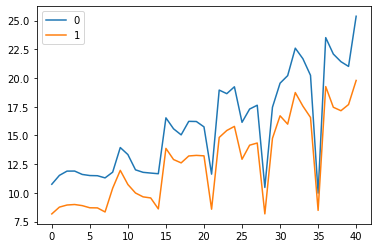

In [89]:
#pd.DataFrame([loss_train_mean[:50],loss_test_mean[:50]]).T.plot()
pd.DataFrame([loss_train_mean,loss_test_mean]).T.plot()

<AxesSubplot:>

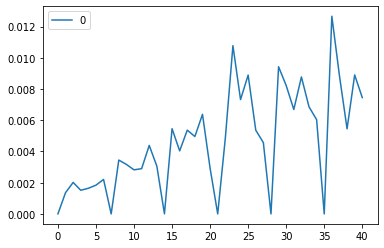

In [90]:
pd.DataFrame(stds).plot()

In [91]:
min_loss

[9.951819071551732, 7.921387273727845]

In [92]:
min_params_test 
#lr, drop, b_size, h_size, decay, i

[0.001, 0.6, 50, 64, 0.012, 12]

<AxesSubplot:>

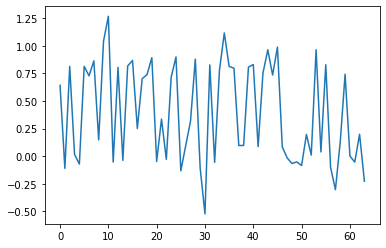

In [64]:
pd.DataFrame(net.fc5.weight.tolist()).max().plot()

In [48]:
np.min(loss_test_mean)

8.686430052511191

In [49]:
np.min(loss_train_mean)

10.565900048965338

In [35]:
loss_test_mean[0]

210.85808172381576

In [51]:
np.min(loss_test)

8.58927655685896

In [51]:
#loss_train=[]
#loss_test=[]
#loss_train_mean=[]
#loss_test_mean=[]
#for i in range(7):
#    window_size=15*(i+1)
#    X,y=df_to_X_y(df,window_size)
#    X_train, X_test, y_train, y_test = train_test_split(X[:],
#                                                        y[:],
#                                                        test_size = 0.10,
#                                                        random_state =123,
#                                                        shuffle=False)
#    parting=X_test.shape[0]//100
#    X_train_part=X_train[::parting]
#    X_test_part=X_test[::parting]
#    y_train_part=y_train[::parting]
#    y_test_part=y_test[::parting]
#    loss=train(drop=0.2, learning_rate=0.004, batch_size=100, epochs=20, momentum=0.9,hidden_size=64,decay=0.00000001)
#    loss_train_mean.append(np.mean(loss[0]))
#    loss_test_mean.append(np.mean(loss[1]))
#    loss_train.append(loss[0])
#    loss_test.append(loss[1])
#    print(i)

In [15]:
net=loss[2]
net(torch.tensor(X_test[:10],device="cuda") )

G:\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([[2241.0277],
        [2302.1876],
        [2296.7581],
        [2301.7366],
        [2329.3609],
        [2250.5947],
        [2344.5514],
        [2286.2322],
        [2292.1030],
        [2230.7599]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MmBackward0>)

In [17]:
y_test[:10]

array([2283.92, 2283.9 , 2285.38, 2285.01, 2284.98, 2284.61, 2285.08,
       2283.36, 2283.38, 2283.98])

In [32]:

print(net.fc2.weight.max(),
net.fc3.weight.max(),
net.fc4.weight.max(),
net.fc5.weight.max(),
net.fc6.weight.max())

tensor(0.1250, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>) tensor(0.1249, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>) tensor(0.1249, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>) tensor(0.2793, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>) tensor(0.1800, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)


In [ ]:
print(net.fc2.bias,
net.fc3.bias,
net.fc4.bias)